In [212]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

NIDS_Data = pd.read_csv("UNSW-NB15-BALANCED-TRAIN.csv", skipinitialspace=True)
NIDS_Data = NIDS_Data.replace(r'\s+', '', regex=True)
NIDS_Data.replace({'attack_cat': {'Backdoor':'Backdoors'}}, inplace=True)
attack_cat_str_values = NIDS_Data['attack_cat'].unique()
NIDS_Data.head()

C:\Users\BloomingLight\AppData\Local\Temp\ipykernel_1320\1712442687.py:23: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  NIDS_Data = pd.read_csv("UNSW-NB15-BALANCED-TRAIN.csv", skipinitialspace=True)


,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.1,55490,149.171.126.3,53,udp,CON,0.001050,146,178,31,...,0.0,3,4,3,2,1,1,1,NaN,0
1,59.166.0.9,26756,149.171.126.8,21,tcp,FIN,4.264797,2934,3738,31,...,4.0,5,5,15,11,5,5,8,NaN,0
2,175.45.176.1,1043,149.171.126.14,53,udp,INT,0.000003,114,0,254,...,NaN,17,17,14,14,14,14,17,Generic,1
3,175.45.176.3,1043,149.171.126.18,53,udp,INT,0.000003,114,0,254,...,NaN,25,25,25,25,25,25,25,Generic,1
4,59.166.0.4,34472,149.171.126.3,10429,tcp,FIN,0.052957,3718,43086,31,...,NaN,5,8,3,2,1,1,2,NaN,0


Get column names from the csv file and read the data using pandas. Head will display the first few rows.
Header was the first row, default = 0.

In [213]:
# factorization
# converting null values to str
NIDS_Data['ct_flw_http_mthd'] = NIDS_Data['ct_flw_http_mthd'].astype('str')
NIDS_Data['is_ftp_login'] = NIDS_Data['is_ftp_login'].astype('str')
NIDS_Data['ct_ftp_cmd'] = NIDS_Data['ct_ftp_cmd'].astype('str')

NIDS_Data["sport"] = pd.to_numeric(NIDS_Data["sport"], errors="coerce")
NIDS_Data["dsport"] = pd.to_numeric(NIDS_Data["dsport"], errors="coerce")

# converting str to int
NIDS_Data['attack_cat'] = pd.factorize(NIDS_Data['attack_cat'])[0]
NIDS_Data['proto'] = pd.factorize(NIDS_Data['proto'])[0]
NIDS_Data['state'] = pd.factorize(NIDS_Data['state'])[0]
NIDS_Data['service'] = pd.factorize(NIDS_Data['service'])[0]

NIDS_Data['ct_flw_http_mthd'] = pd.factorize(NIDS_Data['ct_flw_http_mthd'])[0]
NIDS_Data['is_ftp_login'] = pd.factorize(NIDS_Data['is_ftp_login'])[0]
NIDS_Data['ct_ftp_cmd'] = pd.factorize(NIDS_Data['ct_ftp_cmd'])[0]

NIDS_Data['srcip'] = preprocessing.LabelEncoder().fit_transform(NIDS_Data['srcip'])
NIDS_Data['dstip'] = preprocessing.LabelEncoder().fit_transform(NIDS_Data['dstip'])

feature_cols = list(NIDS_Data.columns[0:-2]) # remove label and attack_cat

X = NIDS_Data[feature_cols] # Features
label = NIDS_Data['Label'] # Variable
attack_cat = NIDS_Data['attack_cat'] # Variable

# train, test, validation data split
X_train, X_temp, attack_cat_train, attack_cat_temp, label_train, label_temp = train_test_split(
    X, attack_cat, label, test_size = 0.2, random_state = 1)
X_test, X_val, attack_cat_test, attack_cat_val, label_test, label_val = train_test_split(
    X_temp, attack_cat_temp, label_temp, test_size = 0.5, random_state = 1)

In [214]:
def entropy(y):
    probs = [] # Probabilities of each class label
    # print(set(y))
    for c in set(y): # Set gets a unique set of values. We're iterating over each value
        num_same_class = sum(y == c)  # Remember that true == 1, so we can sum.
        p = num_same_class / len(y) # Probability of this class label
        probs.append(p)
    
    return sum(-p * np.log2(p) for p in probs)

label_entropy = entropy(label_train)
attack_cat_entropy = entropy(attack_cat_train)
# srcip_entropy = entropy(NIDS_Data['srcip'])

print("Entire set entropy for Label = %.2f" % label_entropy)
print("Entire set entropy for Attack Category = %.2f" % attack_cat_entropy)

Entire set entropy for Label = 1.00
Entire set entropy for Attack Category = 1.81


In [13]:
# !!!!!!! DO NOT RUN THIS CELL UNLESS YOU WANT TO WAIT FOR LIKE 40 MIN LOL !!!!!!!!!

# Let's write some functions that calculates the entropy after splitting on a particular value

def class_probability(feature, y):
    """Calculates the proportional length of each value in the set of instances"""
    # This is doc string, used for documentation
    probs = []
    for value in set(feature):
        select = feature == value # Split by feature value into two classes
        y_new = y[select]         # Those that exist in this class are now in y_new
        probs.append(float(len(y_new))/len(X))  # Convert to float, because ints don't divide well
    return probs

def class_entropy(feature, y):
    """Calculates the entropy for each value in the set of instances"""
    ents = []
    for value in set(feature):
        select = feature == value # Split by feature value into two classes
        y_new = y[select]         # Those that exist in this class are now in y_new
        ents.append(entropy(y_new))
    return ents

def proportionate_class_entropy(feature, y):
    """Calculatates the weighted proportional entropy for a feature when splitting on all values"""
    probs = class_probability(feature, y)
    ents = class_entropy(feature, y)
    return sum(np.multiply(probs, ents)) # Information gain equation

label_entropy_infogain_dict = {}
attack_cat_infogain_dict = {}

print("========= INFORMATION GAIN FOR LABEL ===========")
for c in X.columns:
    new_entropy = proportionate_class_entropy(X_train[c], label_train)
    print("%s %.5f" % (c, label_entropy - new_entropy))
    label_entropy_infogain_dict[c] = label_entropy - new_entropy

print("========= INFORMATION GAIN FOR ATTACK_CAT ===========")
for c in X.columns:
    new_entropy = proportionate_class_entropy(X_train[c], attack_cat_train)
    print("%s %.5f" % (c, attack_cat_entropy - new_entropy))
    attack_cat_infogain_dict[c] = attack_cat_entropy - new_entropy

# !!!!! DO NOT RUN THIS CELL UNLESS YOU WANT TO WAIT FOR LIKE 40 MIN LOL !!!!!!

========= INFORMATION GAIN FOR LABEL ===========
srcip 0.95531
sport 0.67730
dstip 0.95856
dsport 0.57732
proto 0.44289
state 0.60455
dur 0.85137
sbytes 0.95675
dbytes 0.80079
sttl 0.95317
dttl 0.80514
sloss 0.49595
dloss 0.51211
service 0.39613
Sload 0.99333
Dload 0.83220
Spkts 0.54765
Dpkts 0.70088
swin 0.41821
dwin 0.41747
stcpb 0.63681
dtcpb 0.63673
smeansz 0.82405
dmeansz 0.74249
trans_depth 0.30231
res_bdy_len 0.33681
Sjit 0.66194
Djit 0.67989
Stime 0.69400
Ltime 0.69512
Sintpkt 0.72106
Dintpkt 0.82456
tcprtt 0.63376
synack 0.63261
ackdat 0.63253
is_sm_ips_ports 0.30067
ct_state_ttl 0.94966
ct_flw_http_mthd 0.41066
is_ftp_login 0.41735
ct_ftp_cmd 0.41752
ct_srv_src 0.45384
ct_srv_dst 0.46630
ct_dst_ltm 0.47462
ct_src_ ltm 0.46067
ct_src_dport_ltm 0.49141
ct_dst_sport_ltm 0.51454
ct_dst_src_ltm 0.48752
========= INFORMATION GAIN FOR ATTACK_CAT ===========
srcip 1.23792
sport 1.36953
dstip 1.33943
dsport 1.23318
proto 0.92821
state 0.96194
dur 1.35498
sbytes 1.60967
dbytes 1.21972


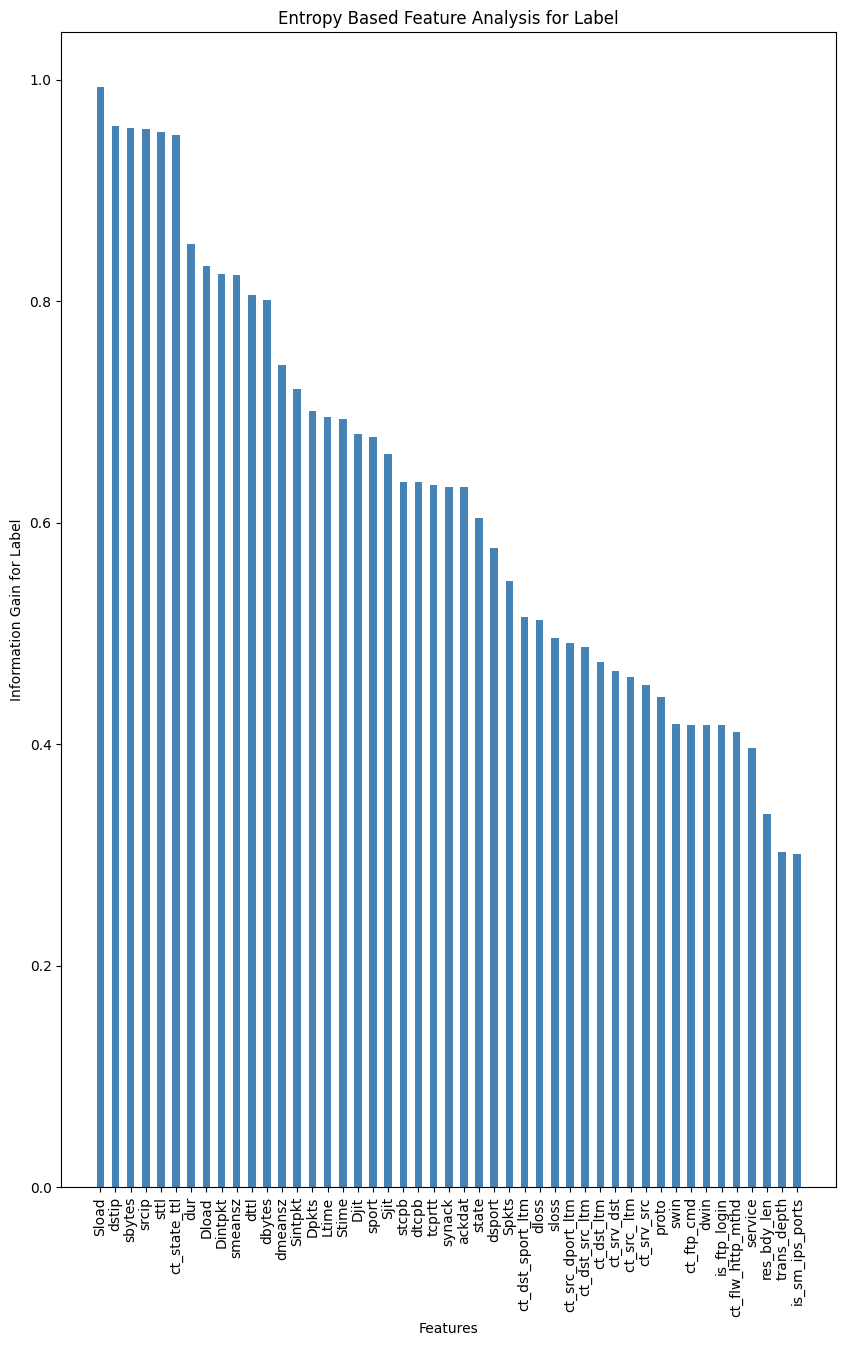

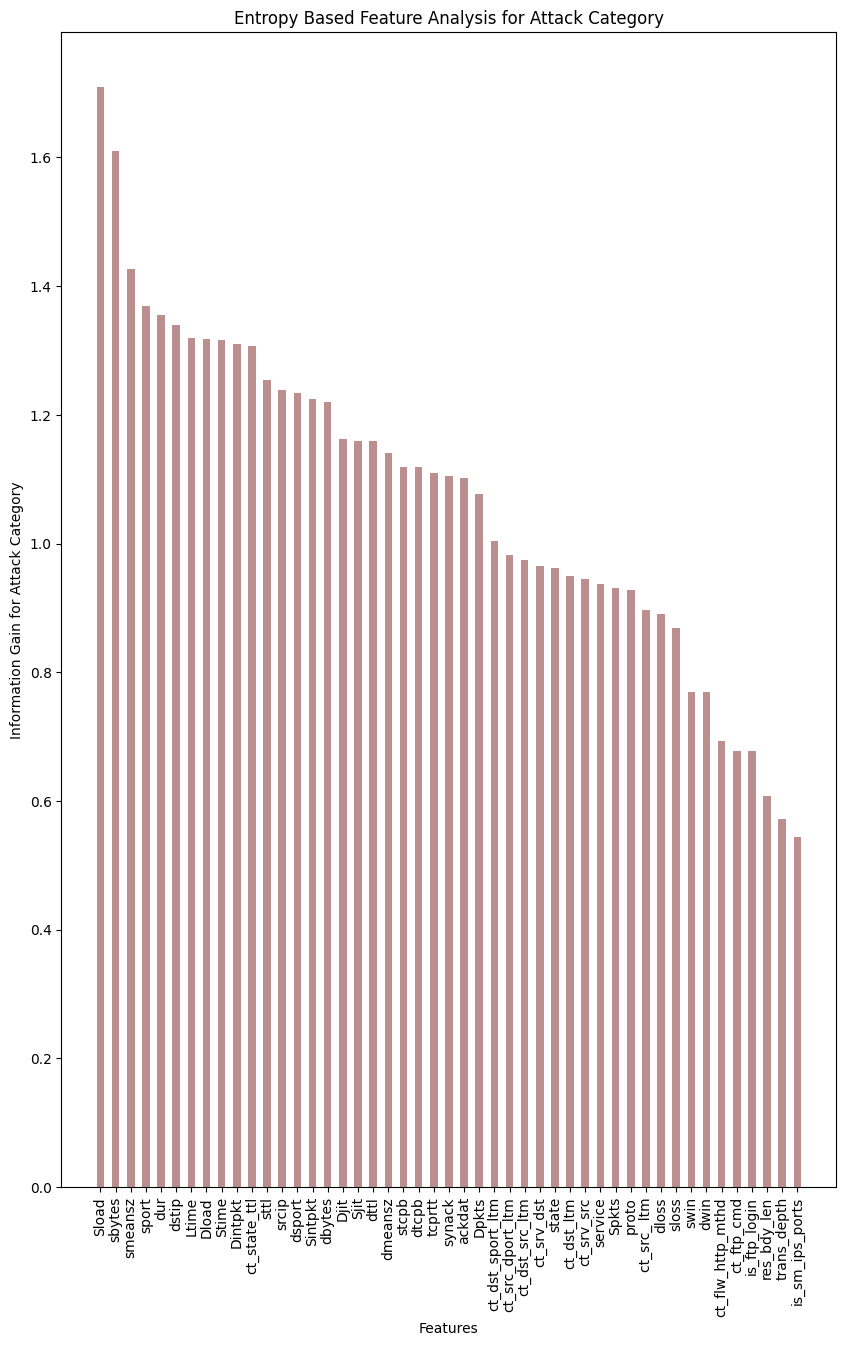

In [230]:
## Feature Selection - Approach - Entropy Based Feature Importance Analysis

## STORE THESE VALUES IN A TXT/JSON FILE FOR CLEANER ACCESS
attack_cat_infogain_dict = {'srcip': 1.2379238930633911, 'sport': 1.3695292877454421, 'dstip': 1.3394266280344709, 'dsport': 1.2331784140625484, 'proto': 0.9282051429213927, 'state': 0.9619429548714097, 'dur': 1.3549839922304838, 'sbytes': 1.6096661410073714, 'dbytes': 1.2197189117360532, 'sttl': 1.2537609910826784, 'dttl': 1.1593181092818514, 'sloss': 0.8685399345674412, 'dloss': 0.8901574615443781, 'service': 0.9366083428908847, 'Sload': 1.7091848132566592, 'Dload': 1.3179978050601797, 'Spkts': 0.9303684132686773, 'Dpkts': 1.0770735354265555, 'swin': 0.7696706515804008, 'dwin': 0.7689310331473325, 'stcpb': 1.1186385903009217, 'dtcpb': 1.1185664010831355, 'smeansz': 1.426903570137386, 'dmeansz': 1.1406467811387737, 'trans_depth': 0.5725187168720958, 'res_bdy_len': 0.6075182837244584, 'Sjit': 1.1598271149566535, 'Djit': 1.1620737285132834, 'Stime': 1.3158972820689034, 'Ltime': 1.3187703044656687, 'Sintpkt': 1.223975840964715, 'Dintpkt': 1.3092946804384944, 'tcprtt': 1.1090384410156224, 'synack': 1.1042762840769624, 'ackdat': 1.101443830524605, 'is_sm_ips_ports': 0.5445300047715642, 'ct_state_ttl': 1.3072637198136012, 'ct_flw_http_mthd': 0.6930564701016266, 'is_ftp_login': 0.6770032215786921, 'ct_ftp_cmd': 0.6771681429440815, 'ct_srv_src': 0.9454129178883062, 'ct_srv_dst': 0.9656466121977691, 'ct_dst_ltm': 0.9490807138987171, 'ct_src_ ltm': 0.8973662715609352, 'ct_src_dport_ltm': 0.9825032294277387, 'ct_dst_sport_ltm': 1.0042293439061372, 'ct_dst_src_ltm': 0.9740857655275139}
label_entropy_infogain_dict = {'srcip': 0.955314260019524, 'sport': 0.6772995576107014, 'dstip': 0.9585628247933012, 'dsport': 0.5773227193740122, 'proto': 0.4428928442310318, 'state': 0.6045543300534324, 'dur': 0.8513693056537538, 'sbytes': 0.9567512176383034, 'dbytes': 0.8007912041037442, 'sttl': 0.9531650428845365, 'dttl': 0.8051421976873394, 'sloss': 0.4959473438809333, 'dloss': 0.5121056278244446, 'service': 0.39612941541107216, 'Sload': 0.9933262987320738, 'Dload': 0.8322003341109165, 'Spkts': 0.5476456276423542, 'Dpkts': 0.7008781300166327, 'swin': 0.41820681806540183, 'dwin': 0.41747355649427376, 'stcpb': 0.6368055683826902, 'dtcpb': 0.6367333791649039, 'smeansz': 0.8240522846865569, 'dmeansz': 0.742494782272227, 'trans_depth': 0.30231206001366573, 'res_bdy_len': 0.3368146917782844, 'Sjit': 0.6619429757010309, 'Djit': 0.6798933045699078, 'Stime': 0.6940023315505754, 'Ltime': 0.695120962151314, 'Sintpkt': 0.721060336403136, 'Dintpkt': 0.8245566948840088, 'tcprtt': 0.6337629462605479, 'synack': 0.6326083415486319, 'ackdat': 0.6325318364682515, 'is_sm_ips_ports': 0.30066820068294176, 'ct_state_ttl': 0.9496648502730091, 'ct_flw_http_mthd': 0.41066329840365823, 'is_ftp_login': 0.41735057705041123, 'ct_ftp_cmd': 0.4175154984158006, 'ct_srv_src': 0.45384126181283513, 'ct_srv_dst': 0.46630224706528156, 'ct_dst_ltm': 0.47461558935464576, 'ct_src_ ltm': 0.4606679010760837, 'ct_src_dport_ltm': 0.491414829692404, 'ct_dst_sport_ltm': 0.5145404671520213, 'ct_dst_src_ltm': 0.48752039607599795}

# label bar plot of information gain
label_sorted_indices = np.argsort(list(label_entropy_infogain_dict.values()))[::-1]
sorted_label_names = [list(label_entropy_infogain_dict.keys())[i] for i in label_sorted_indices]
sorted_label_infogain = [list(label_entropy_infogain_dict.values())[i] for i in label_sorted_indices]


fig = plt.figure(figsize = (10, 15))
plt.bar(sorted_label_names, sorted_label_infogain, color ='steelblue', 
        width = 0.5)
plt.xticks(rotation='vertical')
plt.title('Entropy Based Feature Analysis for Label')
plt.xlabel('Features')
plt.ylabel('Information Gain for Label')
plt.savefig('label.png', bbox_inches="tight")

# attack_cat bar plot of information gain
attack_cat_sorted_indices = np.argsort(list(attack_cat_infogain_dict.values()))[::-1]
sorted_attack_cat_names = [list(attack_cat_infogain_dict.keys())[i] for i in attack_cat_sorted_indices]
sorted_attack_cat_infogain = [list(attack_cat_infogain_dict.values())[i] for i in attack_cat_sorted_indices]

fig = plt.figure(figsize = (10, 15))
plt.bar(sorted_attack_cat_names, sorted_attack_cat_infogain, color ='rosybrown', 
        width = 0.5)
plt.xticks(rotation='vertical')
plt.title('Entropy Based Feature Analysis for Attack Category')
plt.xlabel('Features')
plt.ylabel('Information Gain for Attack Category')
plt.savefig('attack_cat.png', bbox_inches="tight")

In [216]:
# CHECK SCORE WITHOUT USING SELECTED FEATURES ON DTC PART 1 EXPERIMENT

print("Calculating Score without using Selected Features for Label Prediction....")
clf = DecisionTreeClassifier(criterion='entropy')
clf_label = clf.fit(X_train, label_train)
label_pred = clf_label.predict(X_test)
acc_score = metrics.accuracy_score(label_test, label_pred)*100
print("Label Prediction Accuracy: {:.2f}%\n".format(acc_score))

print("Calculating Score without using Selected Features for Attack Category Prediction....")
clf = DecisionTreeClassifier(criterion='entropy')
clf_attack_cat = clf.fit(X_train, attack_cat_train)
attack_cat_pred = clf_attack_cat.predict(X_test)
acc_score = metrics.accuracy_score(attack_cat_test, attack_cat_pred)*100
print("Attack Category Prediction Accuracy: {:.2f}%\n".format(acc_score))

Calculating Score without using Selected Features for Label Prediction....
Label Prediction Accuracy: 99.20%

Calculating Score without using Selected Features for Attack Category Prediction....
Attack Category Prediction Accuracy: 94.14%



In [217]:
# CHECK SCORE AND SELECT FEATURES FOR ENTROPY

num_feat_label = 29
clf = DecisionTreeClassifier(criterion='entropy')
print("Calculating Score using Selected Features for Label Prediction....")
selected_features_label = sorted_label_names[0 : num_feat_label]
X_train_selected_label = X_train[selected_features_label]
X_test_selected_label = X_test[selected_features_label]
clf_label = clf.fit(X_train_selected_label, label_train)
label_pred = clf_label.predict(X_test_selected_label)
acc_score = metrics.accuracy_score(label_test, label_pred)*100
print("Label Prediction Accuracy of EBFI Selected Features: {:.2f}%".format(acc_score))
print("Number of Features Selected: ", num_feat_label)
print("{}\n".format(selected_features_label))

num_feat_attack_cat = 16
clf = DecisionTreeClassifier(criterion='entropy')
print("Calculating Score using Selected Features for Attack Category Prediction....")
selected_features_attack_cat = sorted_attack_cat_names[0 : num_feat_attack_cat]
X_train_selected_attack_cat = X_train[selected_features_attack_cat]
X_test_selected_attack_cat = X_test[selected_features_attack_cat]
clf_attack_cat = clf.fit(X_train_selected_attack_cat, attack_cat_train)
attack_cat_pred = clf_attack_cat.predict(X_test_selected_attack_cat)
acc_score = metrics.accuracy_score(attack_cat_test, attack_cat_pred)*100
print("Attack Category Prediction Accuracy of EBFI Selected Features: {:.2f}%".format(acc_score))
print("Number of Features Selected: ", num_feat_attack_cat)
print("{}\n".format(selected_features_attack_cat))

Calculating Score using Selected Features for Label Prediction....
Label Prediction Accuracy of EBFI Selected Features: 99.25%
Number of Features Selected:  29
['Sload', 'dstip', 'sbytes', 'srcip', 'sttl', 'ct_state_ttl', 'dur', 'Dload', 'Dintpkt', 'smeansz', 'dttl', 'dbytes', 'dmeansz', 'Sintpkt', 'Dpkts', 'Ltime', 'Stime', 'Djit', 'sport', 'Sjit', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'ackdat', 'state', 'dsport', 'Spkts', 'ct_dst_sport_ltm']

Calculating Score using Selected Features for Attack Category Prediction....
Attack Category Prediction Accuracy of EBFI Selected Features: 94.30%
Number of Features Selected:  16
['Sload', 'sbytes', 'smeansz', 'sport', 'dur', 'dstip', 'Ltime', 'Dload', 'Stime', 'Dintpkt', 'ct_state_ttl', 'sttl', 'srcip', 'dsport', 'Sintpkt', 'dbytes']



In [218]:
# GET SCORE ON SELECTED FEATURES FOR RFE

selected_features_label_rfe = ['srcip', 'dstip', 'dsport', 'proto', 'dur', 
                          'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 
                          'dloss', 'service', 'Spkts', 'swin', 'stcpb', 
                          'smeansz', 'dmeansz', 'res_bdy_len', 'Djit', 
                          'Stime', 'Ltime', 'Dintpkt', 'tcprtt', 'synack', 
                          'ct_state_ttl', 'ct_flw_http_mthd', 'ct_srv_src', 
                          'ct_srv_dst', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']

clf = DecisionTreeClassifier(criterion='entropy')
X_train_selected_label = X_train[selected_features_label_rfe]
X_test_selected_label = X_test[selected_features_label_rfe]
clf_label = clf.fit(X_train_selected_label, label_train)
label_pred = clf_label.predict(X_test_selected_label)
acc_score = metrics.accuracy_score(label_test, label_pred)*100
print("Label Prediction Accuracy of RFE Selected Features: {:.2f}%".format(acc_score))

selected_features_attack_cat_rfe = ['srcip', 'dsport', 'sbytes', 'dbytes', 
                                    'sttl', 'dttl', 'sloss', 'dloss', 'service', 
                                    'Spkts', 'swin', 'smeansz', 'dmeansz', 
                                    'tcprtt', 'synack', 'ct_state_ttl', 'ct_srv_dst']

clf = DecisionTreeClassifier(criterion='entropy')
X_train_selected_attack_cat = X_train[selected_features_attack_cat_rfe]
X_test_selected_attack_cat = X_test[selected_features_attack_cat_rfe]
clf_attack_cat = clf.fit(X_train_selected_attack_cat, attack_cat_train)
attack_cat_pred = clf_attack_cat.predict(X_test_selected_attack_cat)
acc_score = metrics.accuracy_score(attack_cat_test, attack_cat_pred)*100
print("Attack Category Prediction Accuracy of RFE Selected Features: {:.2f}%".format(acc_score))

Label Prediction Accuracy of RFE Selected Features: 99.24%
Attack Category Prediction Accuracy of RFE Selected Features: 94.35%


In [123]:
# GET SCORE ON SELECTED FEATURES FOR PCA

selected_features_label_pca = ['Ltime', 'Stime', 'is_ftp_login', 
                               'ct_ftp_cmd', 'tcprtt', 'synack', 
                               'ackdat', 'dttl', 'ct_flw_http_mthd', 
                               'swin', 'dwin', 'ct_srv_src', 'ct_srv_dst', 
                               'ct_src_dport_ltm', 'ct_dst_ltm', 'ct_src_ ltm', 
                               'stcpb', 'dtcpb', 'sttl', 'ct_dst_sport_ltm', 
                               'state', 'ct_dst_src_ltm', 'dbytes', 'dloss']

clf = DecisionTreeClassifier(criterion='entropy')
X_train_selected_label = X_train[selected_features_label_pca]
X_test_selected_label = X_test[selected_features_label_pca]
clf_label = clf.fit(X_train_selected_label, label_train)
label_pred = clf_label.predict(X_test_selected_label)
acc_score = metrics.accuracy_score(label_test, label_pred)*100
print("Label Prediction Accuracy of PCA Selected Features: {:.2f}%".format(acc_score))

selected_features_attack_cat_pca = ['ct_srv_dst', 'ct_srv_src', 'dsport', 
                 'ct_src_ ltm', 'ct_dst_src_ltm', 'dttl', 'ct_dst_ltm', 
                 'ct_src_dport_ltm', 'synack', 'ct_dst_sport_ltm', 
                 'Sload', 'sport', 'state', 'sttl', 'Dload', 
                 'stcpb', 'service', 'res_bdy_len']

clf = DecisionTreeClassifier(criterion='entropy')
X_train_selected_attack_cat = X_train[selected_features_attack_cat_pca]
X_test_selected_attack_cat = X_test[selected_features_attack_cat_pca]
clf_attack_cat = clf.fit(X_train_selected_attack_cat, attack_cat_train)
attack_cat_pred = clf_attack_cat.predict(X_test_selected_attack_cat)
acc_score = metrics.accuracy_score(attack_cat_test, attack_cat_pred)*100
print("Attack Category Prediction Accuracy of PCA Selected Features: {:.2f}%".format(acc_score))

Label Prediction Accuracy of PCA Selected Features: 98.94%
Attack Category Prediction Accuracy of PCA Selected Features: 93.64%


In [219]:
# TRAIN MODELS USING SELECTED FEATURES FROM EBFA AND FIND BEST SCORE FOR LABELS
highest_score = 0
best_depth = 0
num_feat_label = 29

for tree_depth_range in range(30): # 40 depth
    curr_depth = tree_depth_range + 1
    clf = DecisionTreeClassifier(criterion='entropy', max_depth = curr_depth)
    selected_features_label = sorted_label_names[0 : num_feat_label]
    X_train_selected_label = X_train[selected_features_label]
    X_test_selected_label = X_test[selected_features_label]
    clf_label = clf.fit(X_train_selected_label, label_train)
    label_pred = clf_label.predict(X_test_selected_label)
    acc_score = metrics.accuracy_score(label_test, label_pred)*100
    # save highest scoring
    if highest_score < acc_score:
        highest_score = acc_score
        best_depth = curr_depth
        best_num_feat = num_feat_attack_cat
        
print("==================== Decision Tree Classifier ======================")
print("Best Label Prediction Accuracy for EBFI: {:.2f}%".format(highest_score))
print("Best Depth of Decision Tree: {}".format(best_depth))

==================== Decision Tree Classifier ======================
Best Label Prediction Accuracy for EBFI: 99.23%
Best Depth of Decision Tree: 22


In [220]:
# TRAIN MODELS USING SELECTED FEATURES FROM PCA AND FIND BEST SCORE FOR LABELS
highest_score = 0
best_depth = 0

for tree_depth_range in range(30): # 30 depth
    curr_depth = tree_depth_range + 1
    clf = DecisionTreeClassifier(criterion='entropy', max_depth = curr_depth)
    X_train_selected_label = X_train[selected_features_label_pca]
    X_test_selected_label = X_test[selected_features_label_pca]
    clf_label = clf.fit(X_train_selected_label, label_train)
    label_pred = clf_label.predict(X_test_selected_label)
    acc_score = metrics.accuracy_score(label_test, label_pred)*100

    # save highest scoring
    if highest_score < acc_score:
        highest_score = acc_score
        best_depth = curr_depth

print("==================== Decision Tree Classifier ======================")
print("Best Label Prediction Accuracy for PCA: {:.2f}%".format(highest_score))
print("Best Depth of Decision Tree: {}".format(best_depth))

==================== Decision Tree Classifier ======================
Best Label Prediction Accuracy for PCA: 99.25%
Best Depth of Decision Tree: 14


In [221]:
# TRAIN MODELS USING SELECTED FEATURES FROM RFE AND FIND BEST SCORE FOR LABELS
highest_score = 0
best_depth = 0

for tree_depth_range in range(30): # 30 depth
    curr_depth = tree_depth_range + 1
    clf = DecisionTreeClassifier(criterion='entropy', max_depth = curr_depth)
    X_train_selected_label = X_train[selected_features_label_rfe]
    X_test_selected_label = X_test[selected_features_label_rfe]
    clf_label = clf.fit(X_train_selected_label, label_train)
    label_pred = clf_label.predict(X_test_selected_label)
    acc_score = metrics.accuracy_score(label_test, label_pred)*100

    # save highest scoring
    if highest_score < acc_score:
        highest_score = acc_score
        best_depth = curr_depth

print("==================== Decision Tree Classifier ======================")
print("Best Label Prediction Accuracy for RFE: {:.2f}%".format(highest_score))
print("Best Depth of Decision Tree: {}".format(best_depth))

==================== Decision Tree Classifier ======================
Best Label Prediction Accuracy for RFE: 99.28%
Best Depth of Decision Tree: 30


In [222]:
# TRAIN MODELS USING SELECTED FEATURES FROM EBFA AND FIND BEST SCORE FOR ATTACK CAT
highest_score = 0
best_depth = 0
num_feat_attack_cat = 16

for tree_depth_range in range(30): # 40 depth
    curr_depth = tree_depth_range + 1
    clf = DecisionTreeClassifier(criterion='entropy', max_depth = curr_depth)
    selected_features_attack_cat = sorted_attack_cat_names[0 : num_feat_attack_cat]
    X_train_selected_attack_cat = X_train[selected_features_attack_cat]
    X_test_selected_attack_cat = X_test[selected_features_attack_cat]
    clf_attack_cat = clf.fit(X_train_selected_attack_cat, attack_cat_train)
    attack_cat_pred = clf_attack_cat.predict(X_test_selected_attack_cat)
    acc_score = metrics.accuracy_score(attack_cat_test, attack_cat_pred)*100
    # save highest scoring
    if highest_score < acc_score:
        highest_score = acc_score
        best_depth = curr_depth
        best_num_feat = num_feat_attack_cat
        
print("==================== Decision Tree Classifier ======================")
print("Best Attack Category Prediction Accuracy for EBFI: {:.2f}%".format(highest_score))
print("Best Depth of Decision Tree: {}".format(best_depth))

==================== Decision Tree Classifier ======================
Best Attack Category Prediction Accuracy for EBFI: 94.40%
Best Depth of Decision Tree: 25


In [223]:
# TRAIN MODELS USING SELECTED FEATURES FROM PCA AND FIND BEST SCORE FOR ATTACK CAT
highest_score = 0
best_depth = 0

for tree_depth_range in range(30): # 30 depth
    curr_depth = tree_depth_range + 1
    clf = DecisionTreeClassifier(criterion='entropy', max_depth = curr_depth)
    X_train_selected_attack_cat = X_train[selected_features_attack_cat_pca]
    X_test_selected_attack_cat = X_test[selected_features_attack_cat_pca]
    clf_attack_cat = clf.fit(X_train_selected_attack_cat, attack_cat_train)
    attack_cat_pred = clf_attack_cat.predict(X_test_selected_attack_cat)
    acc_score = metrics.accuracy_score(attack_cat_test, attack_cat_pred)*100

    # save highest scoring
    if highest_score < acc_score:
        highest_score = acc_score
        best_depth = curr_depth

print("==================== Decision Tree Classifier ======================")
print("Best Attack Category Prediction Accuracy for PCA: {:.2f}%".format(highest_score))
print("Best Depth of Decision Tree: {}".format(best_depth))

==================== Decision Tree Classifier ======================
Best Attack Category Prediction Accuracy for PCA: 93.94%
Best Depth of Decision Tree: 15


In [224]:
# TRAIN MODELS USING SELECTED FEATURES FROM RFE AND FIND BEST SCORE FOR ATTACK CAT
highest_score = 0
best_depth = 0

for tree_depth_range in range(40): # 30 depth
    curr_depth = tree_depth_range + 1
    clf = DecisionTreeClassifier(criterion='entropy', max_depth = curr_depth)
    X_train_selected_attack_cat = X_train[selected_features_attack_cat_rfe]
    X_test_selected_attack_cat = X_test[selected_features_attack_cat_rfe]
    clf_attack_cat = clf.fit(X_train_selected_attack_cat, attack_cat_train)
    attack_cat_pred = clf_attack_cat.predict(X_test_selected_attack_cat)
    acc_score = metrics.accuracy_score(attack_cat_test, attack_cat_pred)*100

    # save highest scoring
    if highest_score < acc_score:
        highest_score = acc_score
        best_depth = curr_depth

print("==================== Decision Tree Classifier ======================")
print("Best Attack Category Prediction Accuracy for RFE: {:.2f}%".format(highest_score))
print("Best Depth of Decision Tree: {}".format(best_depth))

==================== Decision Tree Classifier ======================
Best Attack Category Prediction Accuracy for RFE: 94.39%
Best Depth of Decision Tree: 23


In [229]:
# PART 2 LABEL SCORES WITH BEST FEATURES SELECTED BY GROUP
# refer to previous cell

clf = DecisionTreeClassifier(criterion='entropy', max_depth = 9)
selected_features_label = selected_features_label_rfe
X_train_selected_label = X_train[selected_features_label]
X_val_selected_label = X_val[selected_features_label]
clf_label = clf.fit(X_train_selected_label, label_train)
label_pred = clf_label.predict(X_val_selected_label)

classifier_name = "Decision Tree Classifier"
print("Classifier: {}\n".format(classifier_name))
print(metrics.classification_report(label_val, label_pred))


clf = DecisionTreeClassifier(criterion='entropy', max_depth = 23)
num_feat_attack_cat = 16
selected_features_attack_cat = sorted_attack_cat_names[0 : num_feat_attack_cat]
X_train_selected_attack_cat = X_train[selected_features_attack_cat]
X_val_selected_attack_cat = X_val[selected_features_attack_cat]
clf_attack_cat = clf.fit(X_train_selected_attack_cat, attack_cat_train)
attack_cat_pred = clf_attack_cat.predict(X_val_selected_attack_cat)

classifier_name = "Decision Tree Classifier"
print("Classifier: {}\n".format(classifier_name))
names = attack_cat_str_values
names[0] = "None"
print(metrics.classification_report(attack_cat_val, attack_cat_pred, target_names=names))

Classifier: Decision Tree Classifier

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     22426
           1       0.99      1.00      0.99     22554

    accuracy                           0.99     44980
   macro avg       0.99      0.99      0.99     44980
weighted avg       0.99      0.99      0.99     44980

Classifier: Decision Tree Classifier

                precision    recall  f1-score   support

          None       1.00      0.99      0.99     22426
       Generic       0.99      0.99      0.99     15107
       Fuzzers       0.79      0.87      0.83      1707
      Exploits       0.65      0.83      0.73      3146
           DoS       0.40      0.29      0.34      1165
Reconnaissance       0.95      0.75      0.84       978
     Backdoors       0.81      0.09      0.16       144
      Analysis       0.46      0.07      0.12       185
     Shellcode       0.85      0.77      0.81       109
         Worms       0.47      0.62 